# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [403]:
import numpy as np
import optimization as opt
import time
import math
from matplotlib import pylab as plt

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

Зеркальный спуск:

$$x^{k + 1} = \arg \min_{x \in \triangle_d} \left( \gamma \langle \nabla f(x^k), x \rangle + KL(x || x^k) \right),$$

где дивергенция Кульбака - Лейблера: 

$$KL(x || x^k) = \sum_{i = 1}^d x_i \log \left( \frac{x_i}{x_i^k} \right)$$

Воспользуемся теоремой Каруша-Куна-Таккера. Запишем Лагранжиан:

$$\mathcal{L}(x, \lambda, \mu) = \gamma \left< \nabla f(x^k), x \right> + \sum_{i = 1}^d x_i \log \left( \frac{x_i}{x_i^k} \right) - \lambda^Tx + \mu \left( \sum_{i=1}^d x_i - 1 \right)$$

1. Условие стационарсности:

$$\frac{\partial \mathcal{L}}{\partial x_i} = \gamma \left( \nabla f(x^k) \right)_i + \log \left( \frac{x_i}{x_i^k} \right) + 1 - \lambda_i + \mu = 0$$

$$x_i = \exp \left( -1 + \lambda_i - \mu - \gamma \left( \nabla f(x^k) \right)_i \right)~x_i^k $$

2. Дополняющая нежесткость: $\lambda_i x_i = 0 \Rightarrow \lambda_i = 0$, если $x_i = x_i^{k + 1} \not = 0$, что тоже самое, что $x_i^k \not = 0$, следовательно $\lambda_i = 0$, если начальная точка не содержит нулевых компонент. То есть:

$$x_i = \exp \left( -1 - \mu - \gamma \left( \nabla f(x^k) \right)_i \right)~x_i^k = \frac{\exp \left( -\gamma \left(\nabla f(x^k) \right)_i \right)}{\exp \left( 1 + \mu \right)}~x_i^k$$

3. Ограничения: $\sum_{i=1}^d x_i = 1$

$$\Sigma = \exp \left( 1 + \mu \right) = \sum_{i=1}^d x_i^k \exp \left( -\gamma \left(\nabla f(x^k) \right)_i \right)$$

То есть: 

$$x_i = \frac{1}{\Sigma}~\exp \left( -\gamma \left(\nabla f(x^k) \right)_i \right) x_i^k$$

Для нашей задачи:

$$\nabla f(x) = \frac{1}{2} \left(A + A^T \right)x$$

Так как матрицу будем брать симметричной, то:

$$\nabla f(x) = Ax$$

$$x_i^{k + 1} = \frac{1}{\Sigma}\exp \left( -\gamma \left( Ax^k \right)_i \right)x_i^k,$$

где:

$$\Sigma = \sum_{i=1}^d x_i^k \exp \left( -\gamma \left( Ax^k \right)_i \right)$$

In [404]:
# Генерация диагональной матрицы
def gen_matrix_diag(d, mu, L, s):
    np.random.seed(s)
    diag = mu + (L - mu) * np.random.sample(d)
    A = np.diag(diag)
    A[0][0] = L
    A[d - 1][d - 1] = mu
    return A


# Генерация матрицы
def gen_matrix(d, mu, L, s):
    np.random.seed(s)
    B = np.random.sample((d, d))
    Q, _ = np.linalg.qr(B)
    C = gen_matrix_diag(d, mu, L, s)
    A = Q @ C @ Q.T
    return A

In [405]:
# Целевая функция
def f(x):
    return 1/2 * x.T @ A @ x


# Градиент функции
def grad_f(x):
    return 1/2 * (A + A.T) @ x

In [406]:
# Зеркальный спуск
def mirror_descent(grad_f, x_0, gamma, iteration, epsilon=10**-7):
    x_now = x_0
    x_next = np.zeros(len(x_0))
    errors = []
    times = [0]

    err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
    errors.append(err)

    start_time = time.time()

    for k in opt.progress(range(iteration)):

        sigma = 0
        for i in range(len(x_0)):
            sigma += np.exp(- gamma * grad_f(x_now)[i]) * x_now[i]

        for i in range(len(x_0)):
            x_next[i] = 1 / sigma * np.exp(- gamma * grad_f(x_now)[i]) * x_now[i]

        x_now = x_next

        err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
        errors.append(err)

        times.append(time.time() - start_time)

        if err < epsilon:c
            break

    return x_now, errors, times

In [407]:
d = 100
mu = 1
L = 1000

s = 6
np.random.seed(s)
A = gen_matrix(d, mu, L, s)
x_0 = np.random.sample(d)

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Перепишем выражение:

$$\text{gap}(x^k) = \langle \nabla f(x^k), x^k \rangle - \min_{y \in \triangle_d} \langle \nabla f(x^k), y \rangle$$

Воспользуемся теоремой Каруша-Куна-Таккера. Запишем Лагранжиан:

$$\mathcal{L}(y, \lambda, \mu) = \left< \nabla f(x^k), y \right> - \lambda^Ty + \mu \left( \sum_{i=1}^d y_i - 1 \right)$$

Условие стационарсности:

$$\frac{\partial \mathcal{L}}{\partial y_i} = \left( \nabla f(x^k) \right)_i - \lambda_i + \mu = 0$$

$$\left( \nabla f(x^k) \right)_i = \lambda_i - \mu$$

Возьмём $\mu = \min\limits_i \left( \nabla f(x^k) \right)_i$, пусть $\mu = \left( \nabla f(x^k) \right)_j$.

Тогда $\lambda_j = 0$, а остальные $\lambda \geq 0$, то есть выполняется условие неотрицательности.

Можно взять $y_j = 1$, а остальные $y = 0$, тогда будет выполнено условие дополняющей нежесткости и ограничения.

То есть:

$$\text{gap}(x^k) = \langle \nabla f(x^k), x^k \rangle - \min_i \left( \nabla f(x^k) \right)_i$$

Для нашей задачи:

$$\nabla f(x) = \frac{1}{2} \left(A + A^T \right)x$$

Так как матрицу будем брать симметричной, то:

$$\nabla f(x) = Ax$$

То есть:

$$\text{gap}(x^k) = \langle Ax^k, x^k \rangle - \min_i \left( Ax^k \right)_i$$

In [408]:
answer_1, error_1, times_1 = mirror_descent(grad_f, x_0, 1 / L, 10000)

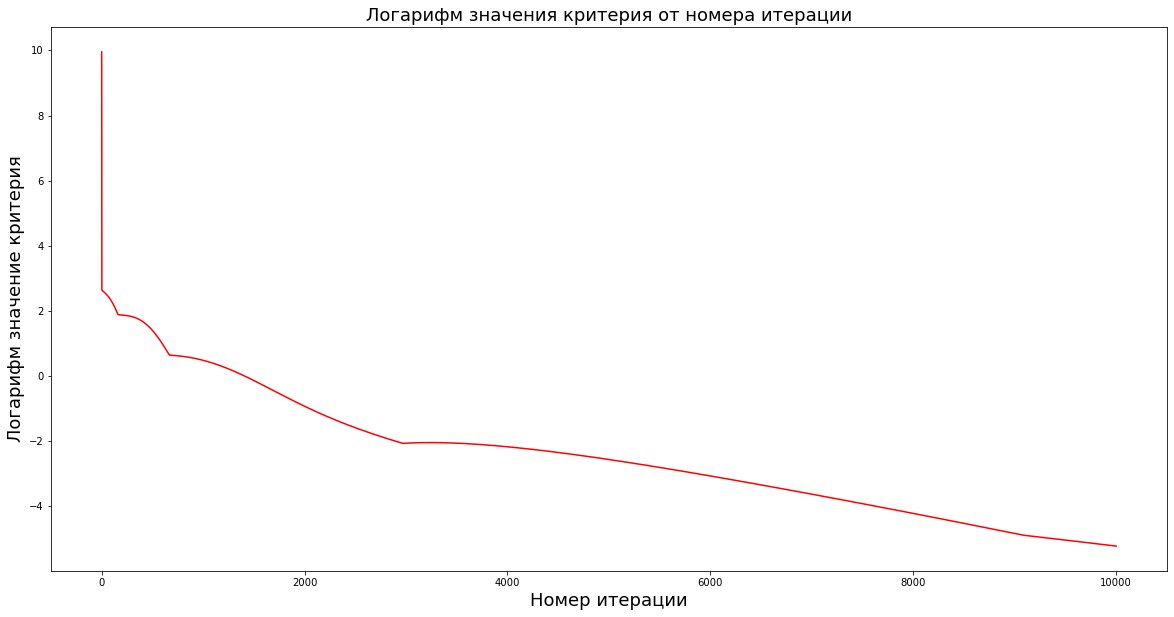

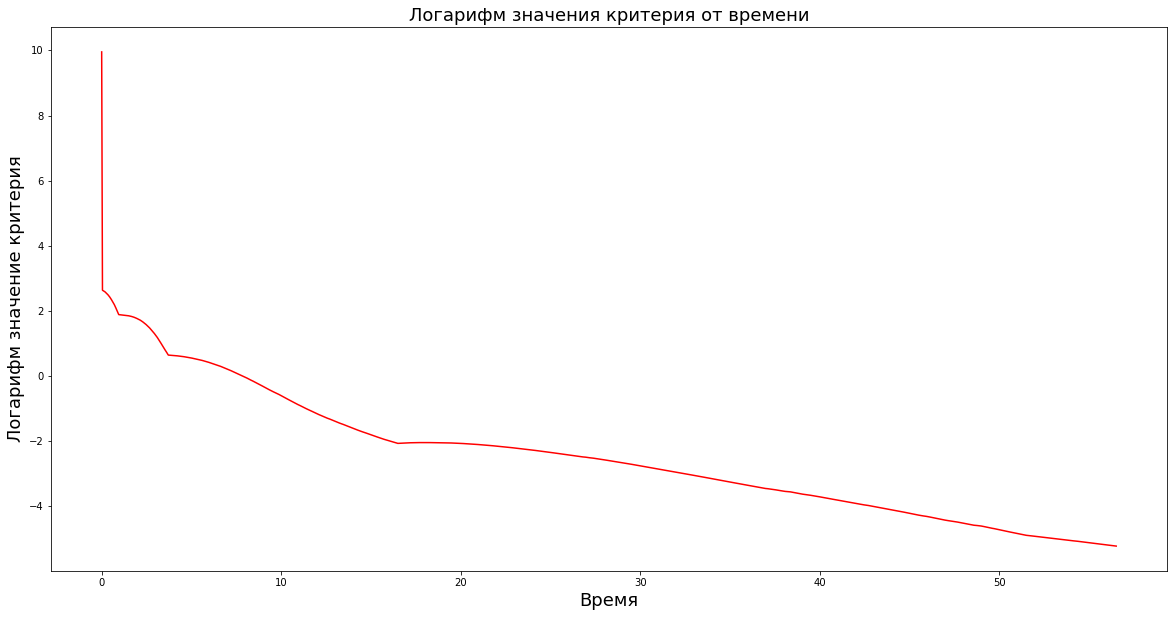

In [409]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_1))), np.log(error_1), "red")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1), np.log(error_1), "red")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

Франк - Вульф:

$$s^k = \arg \min_{s \in \triangle_d} \langle \nabla f(x^k), s - x^k \rangle = \arg \min_{s \in \triangle_d} \langle \nabla f(x^k), s \rangle$$

$$x^{k + 1} = x^k + \gamma_k (s^k - x^k)$$

Из __б)__ минимум достигается при $s_j = 1$, и остальных $s = 0$, где $j$ - это индекс, на которм компонета градиента минимальна.

In [410]:
# Метод Франка - Вульфа
def frank_wolf(grad_f, x_0, gamma, iteration, epsilon=10**-7):
    x_now = x_0
    errors = []
    times = [0]

    err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
    errors.append(err)

    start_time = time.time()

    for k in opt.progress(range(iteration)):

        s = np.zeros(len(x_0))
        grad = grad_f(x_now)[0]
        j = 0
        for i in range(1, len(x_0)):
            if grad_f(x_now)[i] < grad:
                grad = grad_f(x_now)[i]
                j = i
        s[j] = 1

        x_next = x_now + gamma(k) * (s - x_now)
        x_now = x_next

        err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
        errors.append(err)

        times.append(time.time() - start_time)

        if err < epsilon:
            break

    return x_now, errors, times

In [411]:
def gamma(k):
    return 2 / (k + 2)

In [412]:
answer_2, error_2, times_2 = frank_wolf(grad_f, x_0, gamma, 10000)

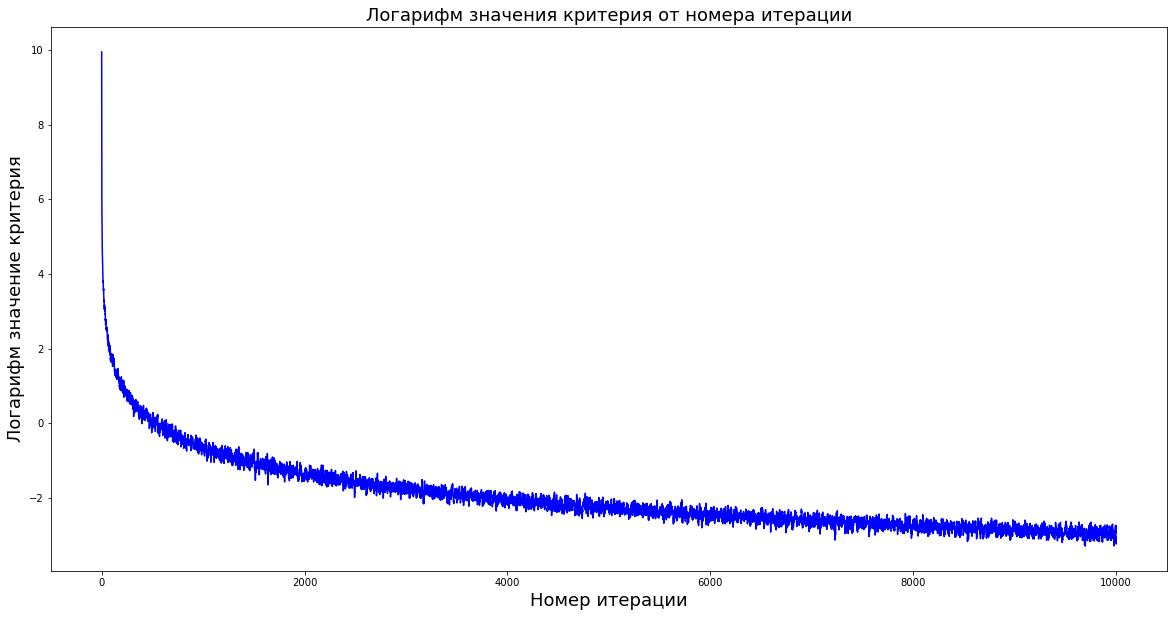

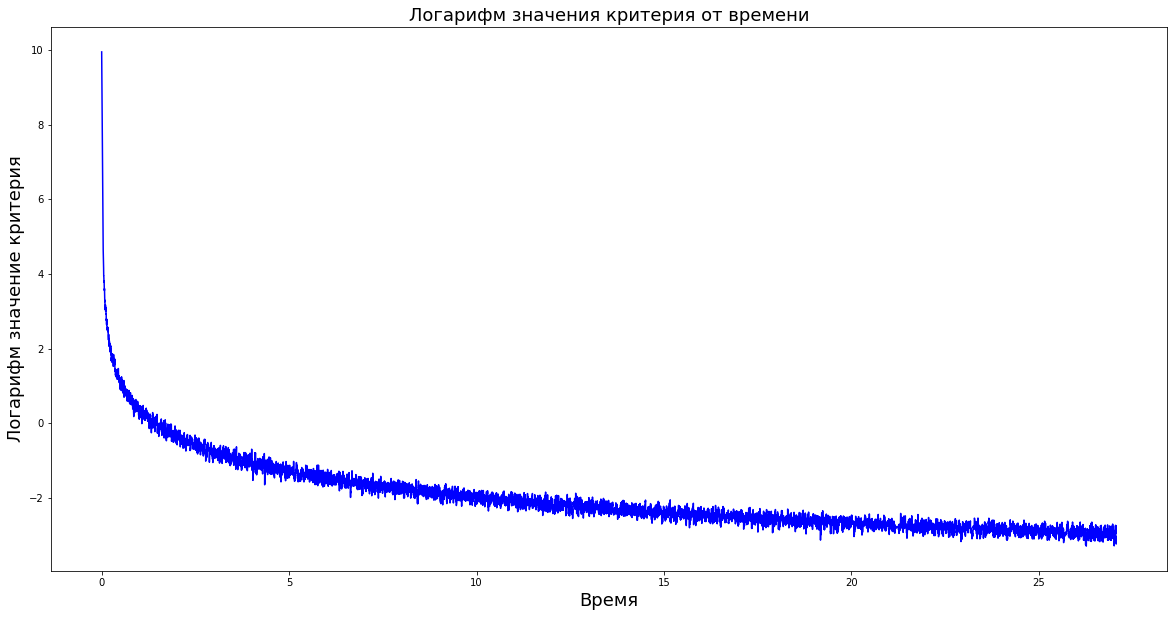

In [413]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_2))), np.log(error_2), "blue")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_2), np.log(error_2), "blue")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

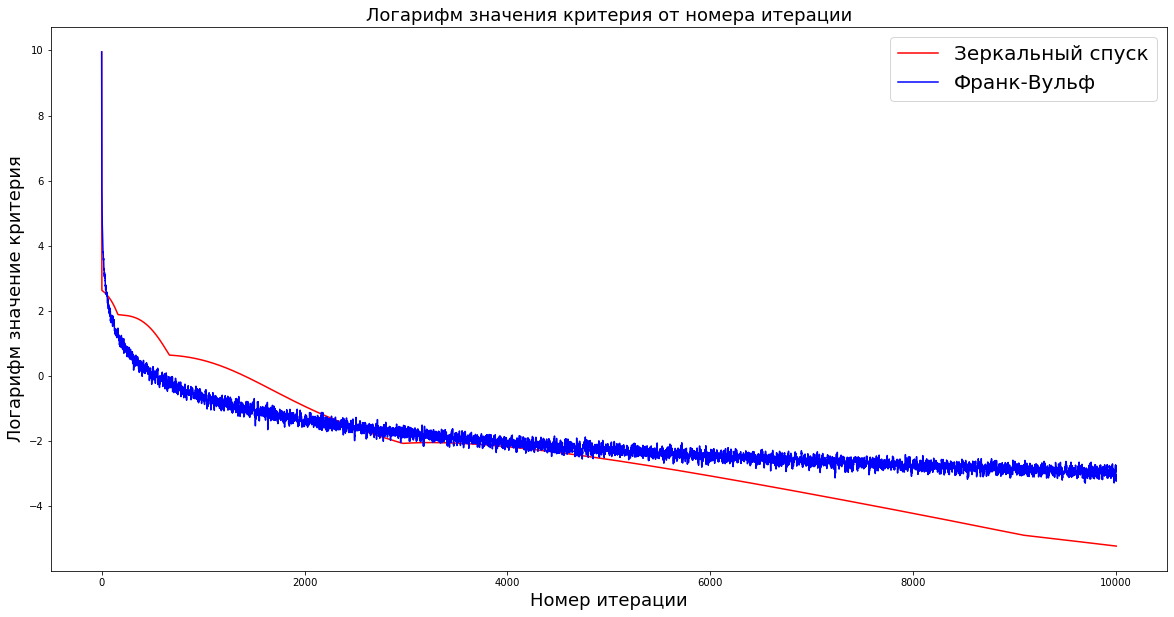

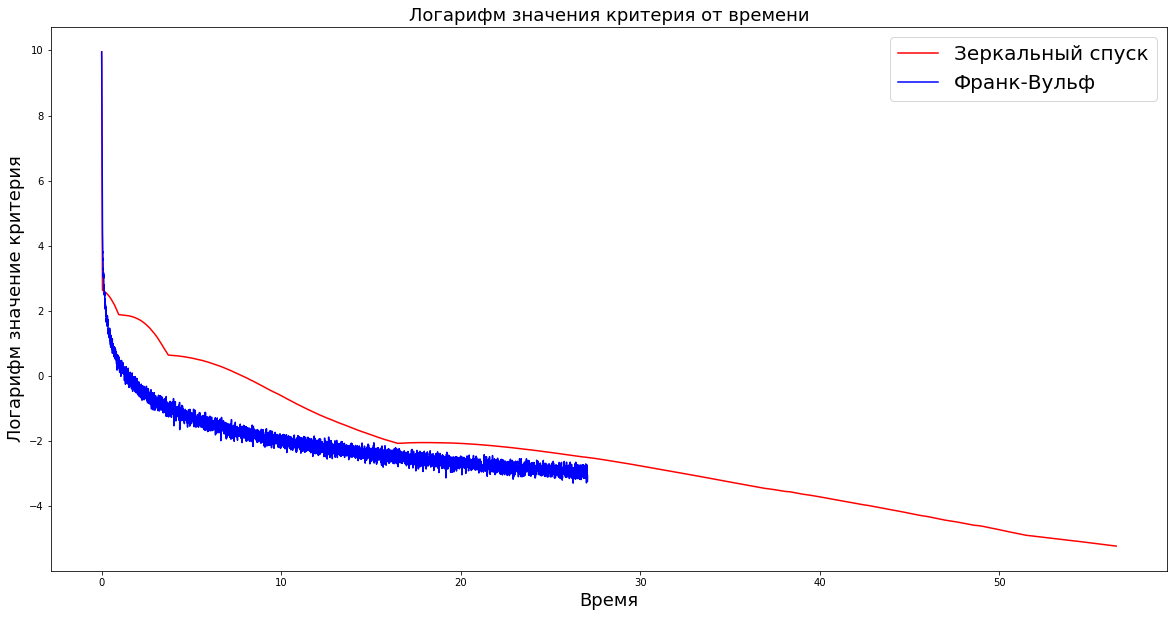

In [414]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_1))), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(range(len(error_2))), np.log(error_2), "blue", label = "Франк-Вульф")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(times_2), np.log(error_2), "blue", label = "Франк-Вульф")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Метод зеркального спуска и метод Франка-Вульфа сходятся примерно одинаково, но метод Франка-Вульфа работает быстрее. У метода Франка-Вульфа есть проблема - осциллирует.

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

Метод проекций:

$$x^{k + 1} = \text{proj}_{\triangle_d} (x^k - \gamma \nabla (x^k))$$

$$\text{proj}_{\triangle_d} (x) = \arg \min_{y \in \triangle_d} \left( \frac{1}{2} \| y - x \|_2^2 \right)$$

Алгоритм я взял из [статьи](https://arxiv.org/pdf/1309.1541.pdf).

In [415]:
# Метод евклидовой проекции на симплекс
def projection_simplex(x):
    x_sort = sorted(x, reverse=True)
    rho = 0
    summa = x_sort[0]
    summa_ans = x_sort[0]
    for i in range(1, len(x_sort)):
        summa += x_sort[i]
        if x_sort[i] + 1 / (i + 1) * (1 - summa) > 0:
            rho = i
            summa_ans = summa
    lamb = 1 / (rho + 1) * (1 - summa_ans)
    x_answer = np.zeros(len(x_sort))
    for i in range(len(x_answer)):
        x_answer[i] = max(x[i] + lamb, 0)
    return x_answer

In [416]:
# Метод градиентного спуска с использванием евклидовой проекции на симплекс
def gradient_simplex(grad_f, x_0, gamma, iteration, epsilon=10**-7):
    x_now = x_0
    errors = []
    times = [0]

    err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
    errors.append(err)

    start_time = time.time()

    for k in opt.progress(range(iteration)):
        
        x_next = projection_simplex(x_now - gamma * grad_f(x_now))
        x_now = x_next

        err = grad_f(x_now).T @ x_now - np.min(grad_f(x_now))
        errors.append(err)

        times.append(time.time() - start_time)

        if err < epsilon:
            break

    return x_now, errors, times

In [417]:
answer_3, error_3, times_3 = gradient_simplex(grad_f, x_0, 1 / L, 10000)

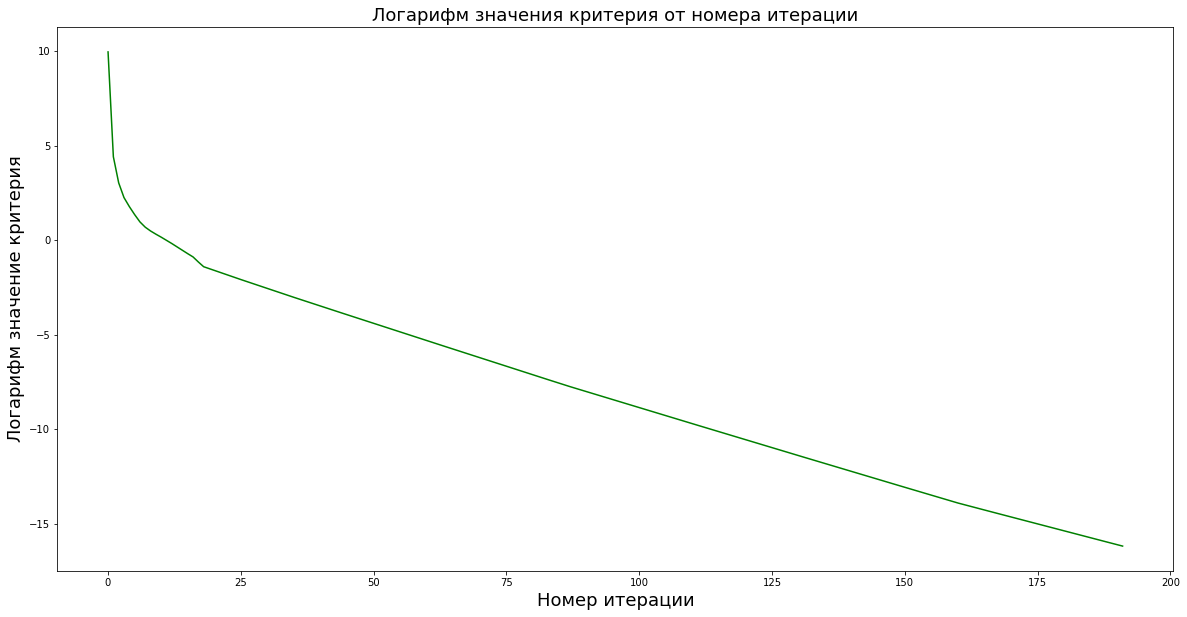

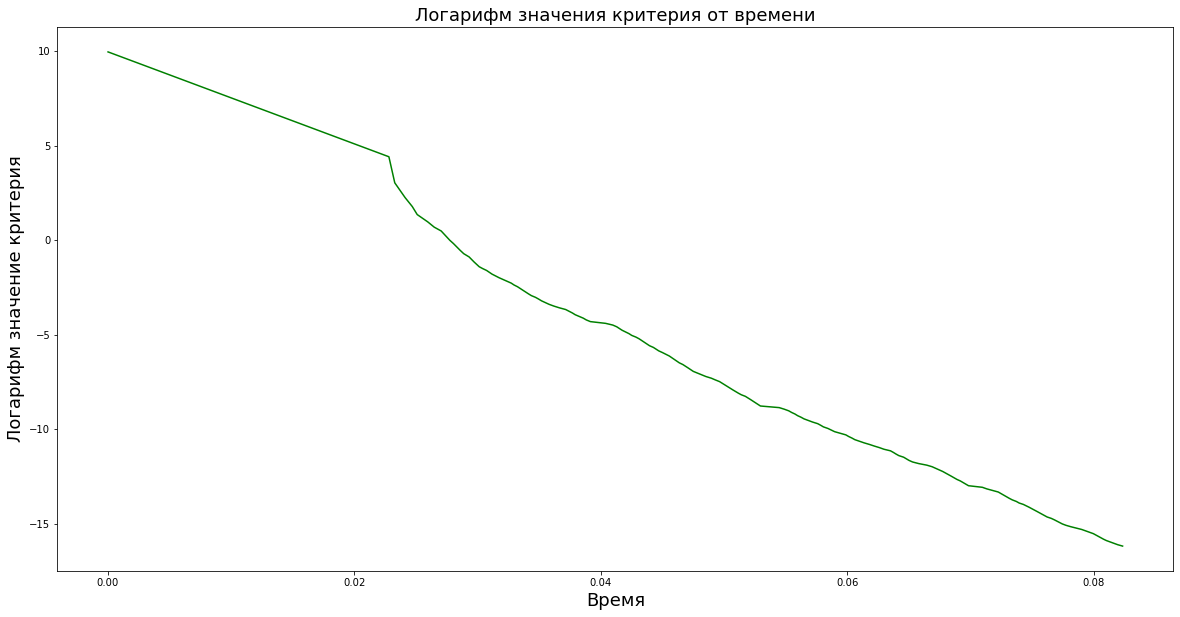

In [418]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_3))), np.log(error_3), "green")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_3), np.log(error_3), "green")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

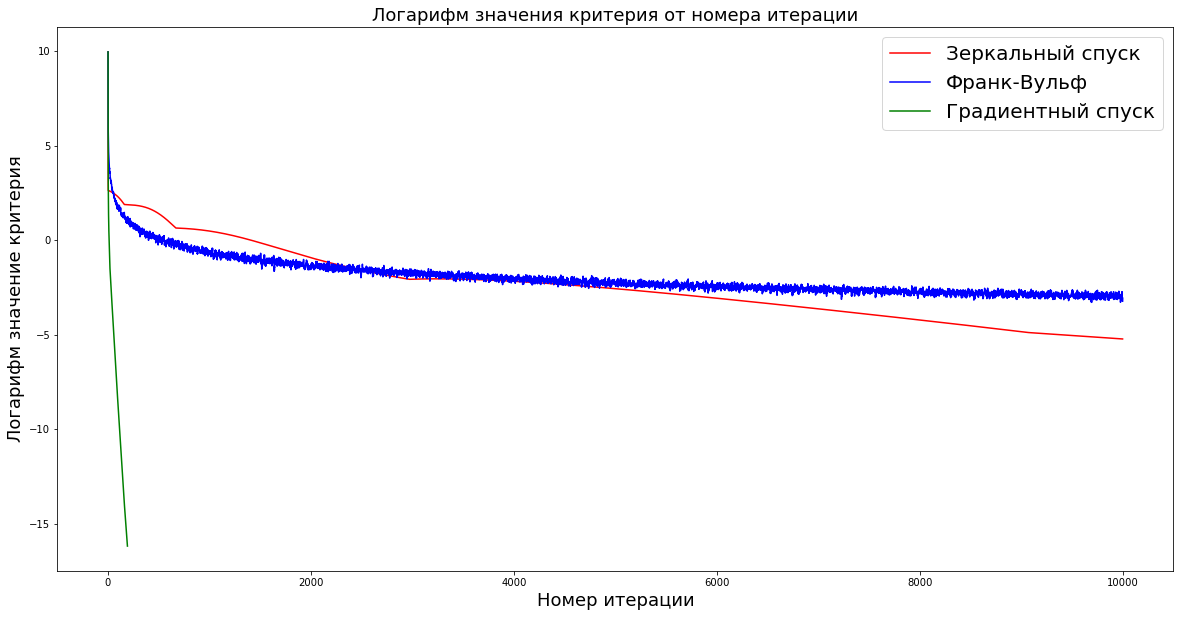

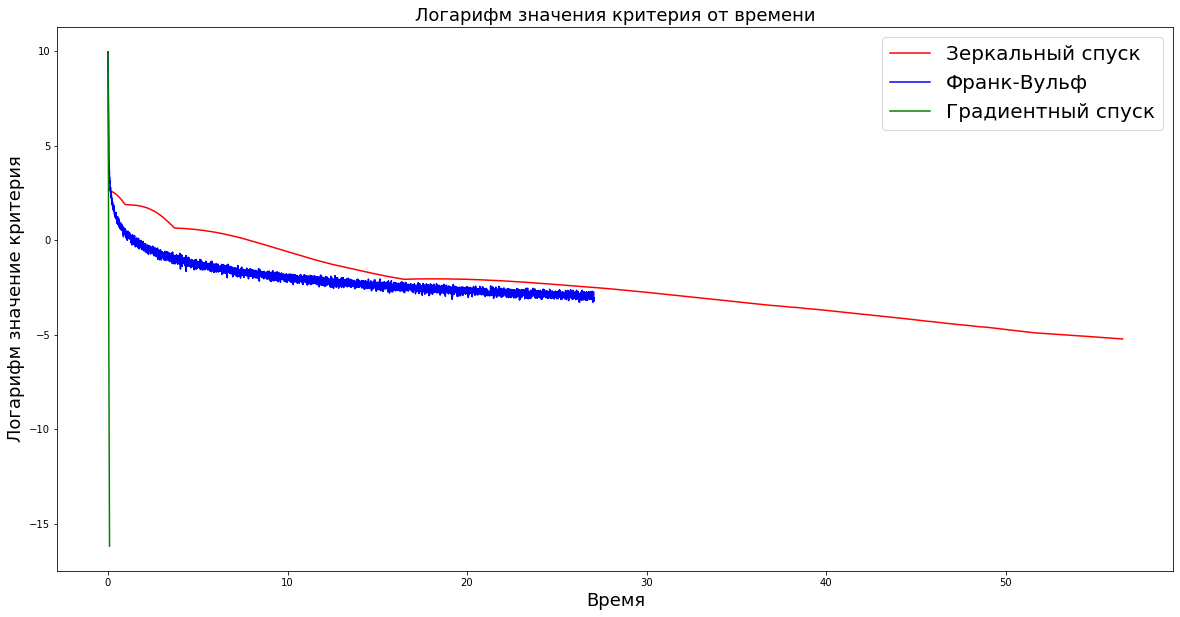

In [419]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_1))), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(range(len(error_2))), np.log(error_2), "blue", label = "Франк-Вульф")
plt.plot(np.array(range(len(error_3))), np.log(error_3), "green", label = "Градиентный спуск")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(times_2), np.log(error_2), "blue", label = "Франк-Вульф")
plt.plot(np.array(times_3), np.log(error_3), "green", label = "Градиентный спуск")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим, градиентный спуск с евклидовой проекцией на симплекс сходится точнее и сильно быстрее, чем метод зеркального спуска и метод Франка-Вульфа.

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [420]:
def CndG(g, u, beta, nu):
    u_now = u
    number = 0
    while True:

        v = np.zeros(len(u))
        minimum = (g + beta * (u_now - u))[0]
        j = 0
        for i in range(1, len(u)):
            if (g + beta * (u_now - u))[i] < minimum:
                minimum = (g + beta * (u_now - u))[i]
                j = i
        v[j] = 1

        W = (g + beta * (u_now - u)).T @ u_now - np.min(g + beta * (u_now - u))

        if W <= nu:
            return u_now
        
        alpha = min(1, ((beta * (u - u_now) - g).T @ (v - u_now)) / (beta * np.linalg.norm(v - u_now, ord=2)**2))
        u_now = (1 - alpha) * u_now + alpha * v

In [421]:
# Ускоренная версия Франка - Вульфа
def frank_wolf_fast(grad_f, x_0, beta, gamma, nu, iteration, epsilon=10**-7):
    x_now = x_0
    y_now = x_0
    errors = []
    times = [0]
    
    err = grad_f(y_now).T @ y_now - np.min(grad_f(y_now))
    errors.append(err)
    
    start_time = time.time()
    
    for k in opt.progress(range(iteration)):
        z = (1 - gamma(k)) * y_now + gamma(k) * x_now
        x_next = CndG(grad_f(z), x_now, beta(k), nu(k))
        y_next = (1 - gamma(k)) * y_now + gamma(k) * x_next
        x_now = x_next
        y_now = y_next
        
        err = grad_f(y_now).T @ y_now - np.min(grad_f(y_now))
        errors.append(err)
        
        times.append(time.time() - start_time)
        
        if err < epsilon:
            break

    return y_now, errors, times

In [422]:
# Ускоренная версия Франка - Вульфа для сильно выпуклых задач
def frank_wolf_fast_strong(grad_f, p_0, beta, gamma, nu, iteration, epsilon=10**-7):
    p_now = p_0
    times = []
    errors = []
    
    start_time = time.time()
    
    for s in opt.progress(range(iteration)):
        process_time = time.time()
        p_now, error, time_work = frank_wolf_fast(grad_f, p_now, beta, gamma, nu(s), N)
        errors += error
        time_work = list(map(lambda time: process_time + time - start_time, time_work))
        times += time_work
    return p_now, errors, times

In [423]:
def beta(k):
    return 2 * L / (k + 1)

def gamma(k):
    return 2 / (k + 2)

def nu(s):
    def nu_k(k):
        return 8 * L * delta * 2**(-(s + 1)) / (mu * N * (k + 1))
    return nu_k

In [424]:
p_0 = x_0 / np.linalg.norm(x_0, ord=2)
p_0[1] = 1
delta = f(p_0)
N = math.ceil(2 * math.sqrt(6 * L / mu))

In [425]:
answer_4, error_4, times_4 = frank_wolf_fast_strong(grad_f, x_0, beta, gamma, nu, 20)

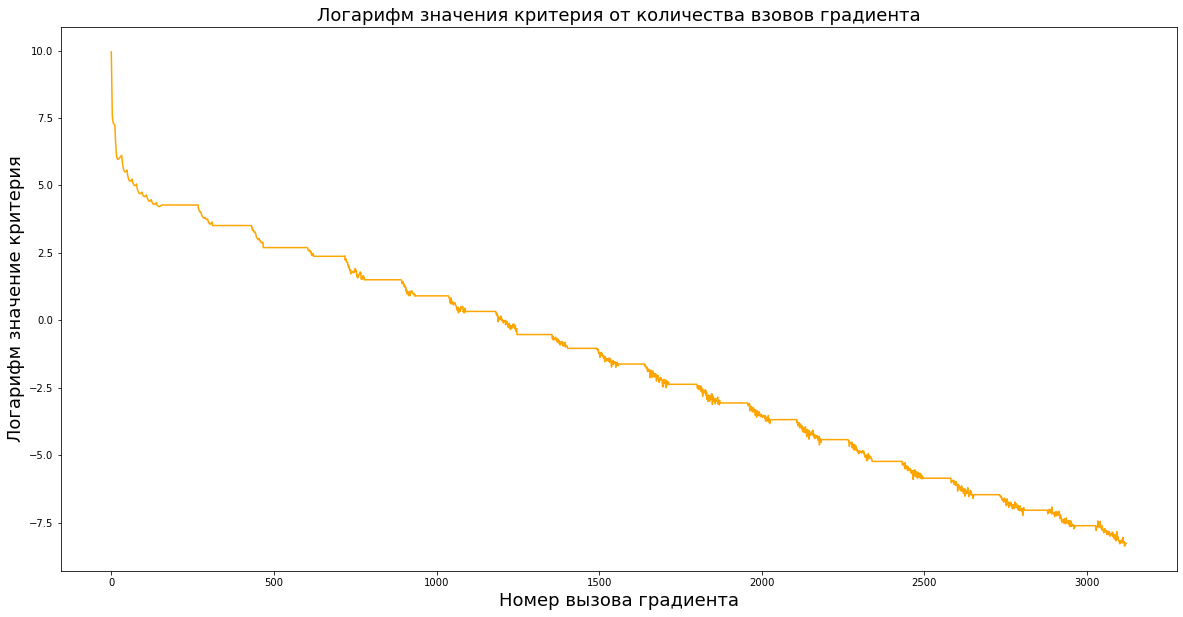

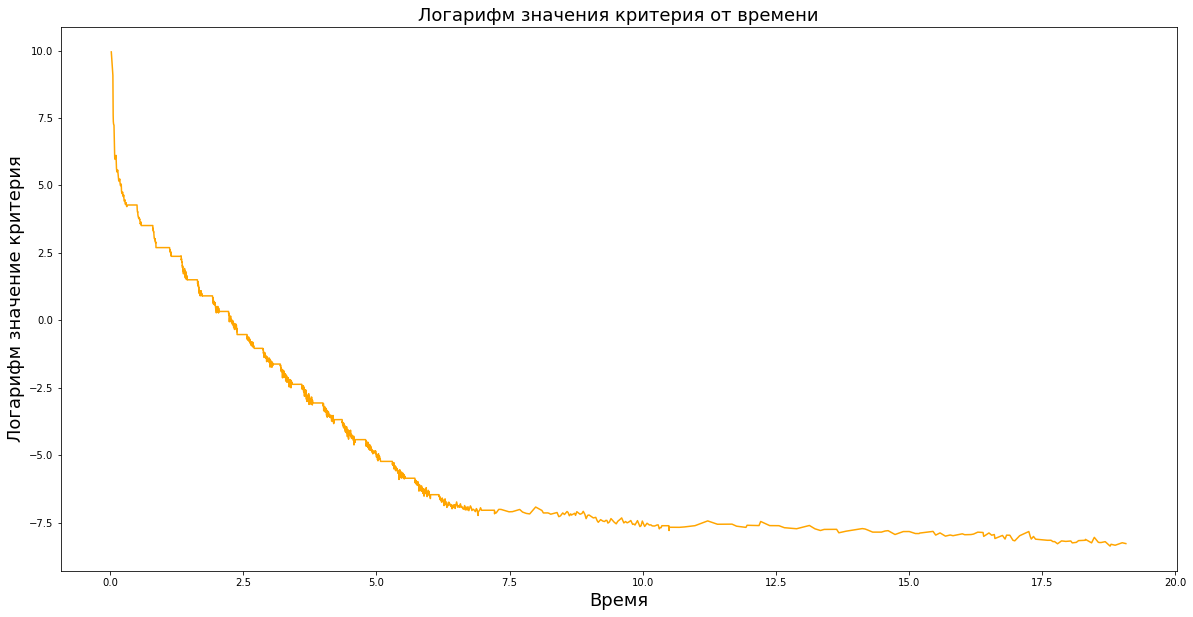

In [426]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_4))), np.log(error_4), "orange")
plt.title("Логарифм значения критерия от количества взовов градиента", fontsize = 18)
plt.xlabel("Номер вызова градиента", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_4), np.log(error_4), "orange")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.show()

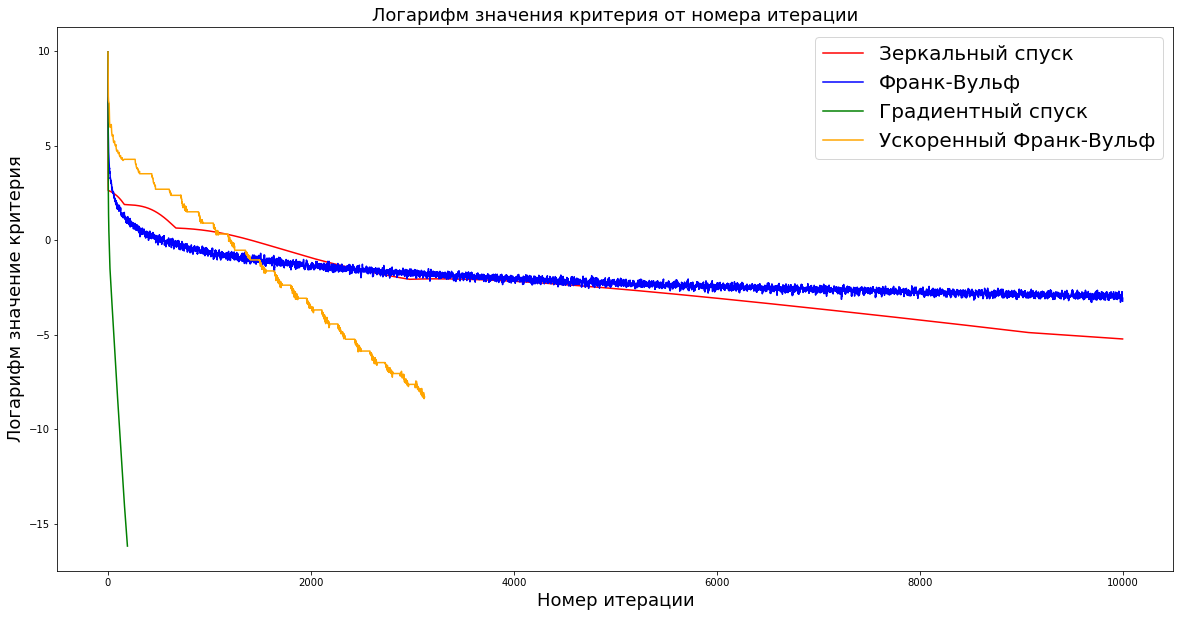

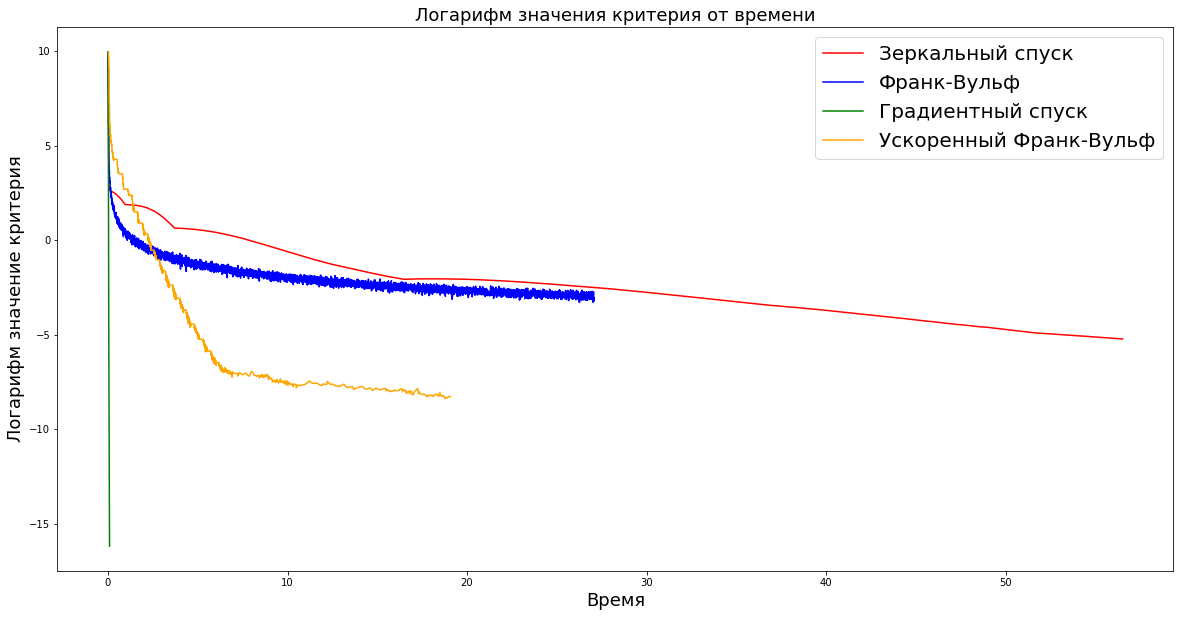

In [427]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(error_1))), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(range(len(error_2))), np.log(error_2), "blue", label = "Франк-Вульф")
plt.plot(np.array(range(len(error_3))), np.log(error_3), "green", label = "Градиентный спуск")
plt.plot(np.array(range(len(error_4))), np.log(error_4), "orange", label = "Ускоренный Франк-Вульф")
plt.title("Логарифм значения критерия от номера итерации", fontsize = 18)
plt.xlabel("Номер итерации", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(np.array(times_1), np.log(error_1), "red", label = "Зеркальный спуск")
plt.plot(np.array(times_2), np.log(error_2), "blue", label = "Франк-Вульф")
plt.plot(np.array(times_3), np.log(error_3), "green", label = "Градиентный спуск")
plt.plot(np.array(times_4), np.log(error_4), "orange", label = "Ускоренный Франк-Вульф")
plt.title("Логарифм значения критерия от времени", fontsize = 18)
plt.xlabel("Время", fontsize = 18)
plt.ylabel("Логарифм значение критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим, градиентный спуск с евклидовой проекцией на симплекс сходится точнее и сильно всего. Ускоренный метод Франка - Вульфа работает лиьно лучше, чем метод зеркального спуска и обычный метод Франка - Вульфа.